In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
from config import db_password
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
# set up the connection to our Postgres db 
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = db_password
POSTGRES_DBNAME = 'db_segment2'

In [3]:
## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))

In [4]:
# Create the connection
cnx = create_engine(postgres_str)


In [5]:
# read the file
merge = pd.read_sql_query('''SELECT * FROM merge;''', cnx)

In [6]:
merge_df = pd.DataFrame(merge)
merge_df

,DBN,ell_num,sped_num,asian_num,black_num,hispanic_num,white_num,male_num,female_num,Total Cohort #,...,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# English Language Learners,# Poverty,Economic Need Index
0,01M292,52.0,124.0,56,158,272,12,281.0,234.0,5,...,125,27,58,127,0,4,6,21,191.00,87.8
1,01M448,54.0,111.0,110,128,232,18,275.0,213.0,59,...,267,141,100,206,1,2,15,49,415.00,82.9
2,01M450,27.0,146.0,34,145,326,33,285.0,261.0,76,...,366,81,113,367,6,6,100,6,447.00,62.9
3,01M458,4.0,19.0,3,59,136,8,96.0,117.0,70,...,86,1,70,121,1,1,9,16,176.00,85.0
4,01M515,462.0,4.0,501,24,24,2,314.0,237.0,234,...,320,318,58,165,0,6,10,392,431.00,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,32K549,52.0,53.0,3,97,237,1,167.0,180.0,57,...,194,4,69,275,1,2,11,118,310.00,92.1
406,32K552,69.0,47.0,5,112,239,3,193.0,170.0,85,...,112,2,35,154,0,0,4,51,187.15,91.2
407,32K554,10.0,15.0,6,53,174,1,120.0,117.0,5,...,194,31,36,332,0,0,35,7,373.00,70.8
408,32K556,58.0,35.0,5,54,231,1,122.0,178.0,77,...,155,2,48,222,0,0,3,75,266.95,92.7


In [7]:
# counts the number of not empty values for each row
merge_df.count()

DBN                            410
ell_num                        400
sped_num                       398
asian_num                      410
black_num                      410
hispanic_num                   410
white_num                      410
male_num                       404
female_num                     409
Total Cohort #                 410
Total Grads #                  410
Total Regents #                410
Advanced Regents #             410
Regents w/o Advanced #         410
Local #                        410
Still Enrolled #               410
Dropped Out #                  410
School Name                    410
Year                           410
Total Enrollment               410
# Female                       410
# Male                         410
# Asian                        410
# Black                        410
# Hispanic                     410
# Multi-Racial                 410
# Native American              410
# White                        410
# English Language L

In [8]:
merge_df = merge_df.fillna(0)

In [9]:
merge_df.count()

DBN                            410
ell_num                        410
sped_num                       410
asian_num                      410
black_num                      410
hispanic_num                   410
white_num                      410
male_num                       410
female_num                     410
Total Cohort #                 410
Total Grads #                  410
Total Regents #                410
Advanced Regents #             410
Regents w/o Advanced #         410
Local #                        410
Still Enrolled #               410
Dropped Out #                  410
School Name                    410
Year                           410
Total Enrollment               410
# Female                       410
# Male                         410
# Asian                        410
# Black                        410
# Hispanic                     410
# Multi-Racial                 410
# Native American              410
# White                        410
# English Language L

# PreProcessing the Data


## 1.First, we define the features set.

In [10]:
# Define the features set.
X = merge_df.copy()
X = X.drop(columns=["DBN","asian_num","black_num","hispanic_num","white_num","School Name","Year","Dropped Out #"])
            
X.head()

,ell_num,sped_num,male_num,female_num,Total Cohort #,Total Grads #,Total Regents #,Advanced Regents #,Regents w/o Advanced #,Local #,...,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# English Language Learners,# Poverty,Economic Need Index
0,52.0,124.0,281.0,234.0,5,4.0,0.0,0.0,0.0,4.0,...,125,27,58,127,0,4,6,21,191.0,87.8
1,54.0,111.0,275.0,213.0,59,31.0,19.0,3.0,16.0,12.0,...,267,141,100,206,1,2,15,49,415.0,82.9
2,27.0,146.0,285.0,261.0,76,65.0,64.0,0.0,64.0,1.0,...,366,81,113,367,6,6,100,6,447.0,62.9
3,4.0,19.0,96.0,117.0,70,12.0,9.0,0.0,9.0,3.0,...,86,1,70,121,1,1,9,16,176.0,85.0
4,462.0,4.0,314.0,237.0,234,59.0,59.0,37.0,22.0,0.0,...,320,318,58,165,0,6,10,392,431.0,95.0


## 2.Next, we define the target set. Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.



In [11]:
# Define the target set.
y = merge_df["Dropped Out #"].ravel()
y[:5]

array([  1.,   6.,   2.,  40., 104.])

## 3. Now, we split into the training and testing sets.
##    Train =80%, Test = 20%

In [12]:
# # Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2,random_state=78)

In [13]:
# Print the shape of X_train, X_test, y_train, and y_test. Add the following code to do this:

print("X_train : ",X_train.shape)

print("X_test : ",X_test.shape)

print("y_train : ",y_train.shape)

print("y_test : ",y_test.shape)



X_train :  (328, 23)
X_test :  (82, 23)
y_train :  (328,)
y_test :  (82,)


## 4. Lastly, we can create the StandardScaler instance, fit the scaler with the training set, and scale the data.



In [14]:
# Creating a StandardScaler instance.
#scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
#X_scaler = scaler.fit(X_train)

# Scaling the data.
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)


#   feature engineering and the feature selection
## Fit the Model, Make Predictions, and Evaluate Results

## Regression models

In [15]:
#  Create a random forest regressor.
rf_model = RandomForestRegressor(n_estimators=200, random_state=78) 

In [16]:
# # Fitting the model
rf_model = rf_model.fit(X_train, y_train)
rf_model

RandomForestRegressor(n_estimators=200, random_state=78)

In [17]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test)

In [18]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)

0.6075674602498352

## DecisionTreeRegressor

In [19]:
# Training the Decision Tree Regression model on the Training set
from sklearn.tree import DecisionTreeRegressor
rf_model = DecisionTreeRegressor(random_state = 0)
rf_model = rf_model.fit(X_train, y_train)
rf_model

DecisionTreeRegressor(random_state=0)

In [20]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)

In [21]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2 = r2_score(y_test,predictions)
print('r2 score for a worse model is', r2)

r2 score for a worse model is -0.27157994218157877


## Support Vector Regression

In [22]:
# Training the Support Vector Regression model on the Training set
from sklearn.svm import SVR
rf_model = SVR(kernel = 'rbf')
rf_model = rf_model.fit(X_train, y_train)
rf_model


SVR()

In [23]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)

In [24]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)


0.08506255826618381

##  multiple linear regression 

In [25]:
# Training the multiple regression model on the Training set
from sklearn.linear_model import LinearRegression
rf_model = LinearRegression()
rf_model = rf_model.fit(X_train, y_train)
rf_model

LinearRegression()

In [26]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)


In [27]:
# get the training  set accuracy scores.
rf_model.score(X_train, y_train)

0.9902008274310408

In [28]:
# get the test set accuracy scores.
rf_model.score(X_test, y_test)

0.9844782486300152

In [29]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)


0.9844782486300152

In [30]:
predictedPrice = pd.DataFrame(rf_model.predict(X), columns=['Predicted Price']) # Create new dataframe of column'Predicted Price'
actualPrice = pd.DataFrame(y, columns=['Actual Price'])
actualPrice = actualPrice.reset_index(drop=True) # Drop the index so that we can concat it, to create new dataframe
df_actual_vs_predicted = pd.concat([actualPrice,predictedPrice],axis =1)
df_actual_vs_predicted.T

,0,1,2,3,4,5,6,7,8,9,...,400,401,402,403,404,405,406,407,408,409
Actual Price,1.000000,6.000000,2.000000,40.000000,104.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,1.00000,0.000000,7.000000,3.000000,13.000000,7.000000,21.000000,0.000000,11.000000,57.000000
Predicted Price,-0.182839,7.003348,-0.163971,38.730655,98.943792,2.119565,2.767481,-0.238971,0.383843,2.406094,...,0.99226,0.388057,6.885482,2.642069,11.147824,7.249769,20.361868,0.058928,14.463391,56.092685


Text(0.5, 1.0, ' Actaul dropout numbers Vs predicted dropout numbers')

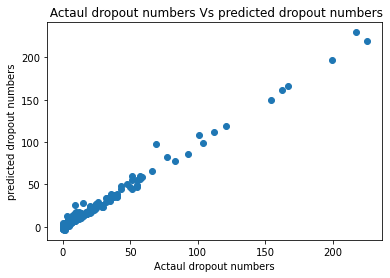

In [31]:
import matplotlib.pyplot as plt
plt.scatter(y,rf_model.predict(X))
plt.xlabel('Actaul dropout numbers')
plt.ylabel('predicted dropout numbers')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title(" Actaul dropout numbers Vs predicted dropout numbers")

In [32]:
print("Multiple linear regression: 98%")
print("Support Vector Regression: 5%")
print("Decision Tree Regression: 35%")
print("Random Forest Regression: 61%")

Multiple linear regression: 98%
Support Vector Regression: 5%
Decision Tree Regression: 35%
Random Forest Regression: 61%


## Multiple linear regression performed the best out of all the four regression models. So we decided to go with this model to predict output values. We didn't see any limitations as the accuracy score is near 100%.
## Benefit: This approach has led to a more accurate and precise understanding of the association of each factor with the outcome.
